# Project 3: Behavioral Cloning

The project aims to develop a model which is able to drive a car around a track in a simulator. The model takes 



mention model py files, copy functions again (doc strinf)

## 1. Collect training data

We drove around the track just twice. This resulted in 8364 instances (2788 images of the center, left and right cameras respectively). Surprisingly this small data set is sufficient to train a model which is able to drive a car reliably without a safety incident. Of course, the model would benefit from additional data (e.g. this could enable the model to drive the mountain track as well). Some possible data collection strategies are given in section 5.

## 2. Load and explore data

First, let's have a quick look at the actual data. For each drive in the simulator a steering angle information (from the human driver) and three images (center, left and right cameras) are recorded. The function *read_driver_log* processes the data of the driver logbook and extracts the paths to the three images (per instance) and the corresponding steering angle (ground truths). In principle the file also contains information about e.g. throttle or speed. We don't use this information but it makes sense to include them in a more advanced model.

In [16]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import os
import csv
from sklearn.model_selection import train_test_split
import random
import sklearn

%matplotlib inline  


def display_images(images, figsize = (15, 10), title=None, fontsize=20, ncols=5):
    "Display images in ncols columns. Choose gray-scale colorbar if image is two-dimensional."
    nrows = np.ceil(len(images)/ncols)
    
    fig = plt.figure(figsize = figsize)
    for i, image in enumerate(images, start = 1):
        ax = fig.add_subplot(nrows, ncols, i)
        if title is not None:
            ax.set_title(title[i-1], fontsize=fontsize)
        plt.imshow(image) if len(image.shape) == 3 else plt.imshow(image, cmap='gray')
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()

In [17]:
def read_driver_log(path):
    """Read driving_log of simulator and extract path to center, left and right camera images and steering angle."""
    data_set = []
    with open(path) as csvfile:
        dir_name = os.path.dirname(path)
        reader = csv.reader(csvfile)
        next(reader)
        for line in reader:
            data_set.append({'center': os.path.join(dir_name, line[0].strip()), 
                             'left': os.path.join(dir_name, line[1].strip()), 
                             'right': os.path.join(dir_name, line[2].strip()), 
                             'steering': float(line[3])})
    return data_set
        
        
data_set = read_driver_log('./my_data/driving_log.csv')

In [20]:
data_set[0]

{'center': '/home/wca3rt/learning/moocs/udacity_selfcar/CarND-Behavioral-Cloning-P3/my_data/IMG/center_2018_06_17_13_46_57_300.jpg',
 'left': '/home/wca3rt/learning/moocs/udacity_selfcar/CarND-Behavioral-Cloning-P3/my_data/IMG/left_2018_06_17_13_46_57_300.jpg',
 'right': '/home/wca3rt/learning/moocs/udacity_selfcar/CarND-Behavioral-Cloning-P3/my_data/IMG/right_2018_06_17_13_46_57_300.jpg',
 'steering': 0.0}

The the next set of images presents sample images of the center, left and right camera. Besides the actual lane the images contain many background structures like the sky which can distract our model. Therefore it makes sense to crop each image such that only the lane is contained.

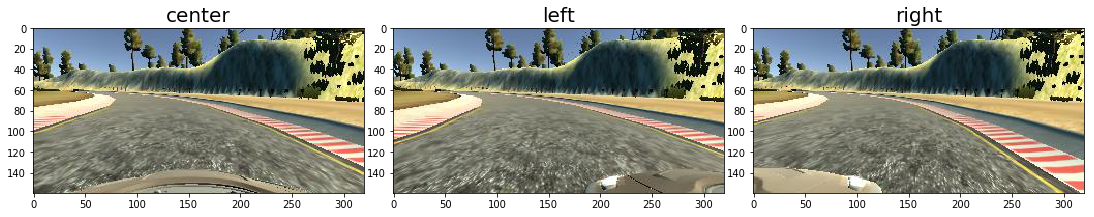

In [27]:
img1 = image = mpimg.imread(data_set[0]['center'])
img2 = image = mpimg.imread(data_set[0]['left'])
img3 = image = mpimg.imread(data_set[0]['right'])

display_images([img1, img2, img3], figsize=(15, 10), ncols=3, title=['center', 'left', 'right'])

## 3. Data pre-processing

It is necessary to pre-process the data to train a model successfully. We apply the following three pre-processing steps to each image
* convert RGB image to another color space: YUV
* crop image
* resize image.

It was found empirically that the conversion to another color space stabilizes the driving behaviour of the model. The advantage of cropping was discussed in the previous section: It helps to focus the model on the things which matter. Resizing the image is requiered so that it fits to the input layer of the NIVIDA-model (see below). 

A very important strategy to keep the car on the lane and to enlarge the original training data set of the center images is to use the left and right camera images as well. The steering angle always refers to the center image. We can guess a reasonable steering angle for the left and right images with
$$\theta_{left} = \theta_{center} + 0.2$$
and
$$\theta_{right} = \theta_{center} - 0.2.$$
The small correction factors to the steering angle of the center image guarantees that the model drives back to the center of the lane if it slightly deviates. 

We also use data augmentation to enlarge the size of the training data set (to combat overfitting). We flip randomly each image (inverting the steering angle at the same time) and change randomly the brightness of each image by at maximum 30%.

The discussed functionalty is wrapped in the function *batch_generator*. It generates *batch_size* samples with the discussed properties. In particular it does not generate all samples of the entire data set at once but *batch_size* samples for each call. This is important to limit memory consumption.

In [29]:
HEIGHT, WIDTH, CHANNELS = 66, 200, 3 


def get_image(sample):
    """Get either the iamge of center, left or right camera and change steering angle appropriately."""
    label = random.choice(['left', 'center', 'right'])
    image = mpimg.imread(sample[label])
    image = image.astype('uint8')
    if label=='left':
        angle = sample['steering'] + 0.2
    elif label=='center':
        angle = sample['steering']
    if label=='right':
        angle = sample['steering'] - 0.2
    return image, angle


def pre_process(image):
    """Pre-process image:
       - convert to other colorspace
       - crop image
       - resize image
    """
    # transform to other colorspace
    image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    # crop image
    image = image[65:125, :, :]
    # resize image
    image = cv2.resize(image, (WIDTH, HEIGHT))
    return image


def flip(image, angle, prob):
    """Flip every 'prob' image and invert its steering angle."""
    if np.random.rand()<prob:
        image = cv2.flip(image, 1)
        angle = -1*angle
    return image, angle


def brightness(image):
    """Change brightness of image randomly (maximum 30%)"""
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    scale = 1.0 + np.random.uniform(-0.3, 0.3)
    hsv[:,:,2] =  hsv[:,:,2] * scale
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)


def augmentation(image, angle):
    """Apply augmentation techniques to image.
    
    - flip image
    - change brightness of image
    
    Args:
       image -- orginal image
       angle -- original streering angle
    """
    image, angle = flip(image, angle, 0.5)
    image = brightness(image)
    return image, angle

        
def batch_generator(data_set, batch_size=32, is_training=False):
    """Return batches of size batch_size for each function call."""
    num_samples = len(data_set)
    # one iteration of while-loop corresponds to one epoch
    while True:
        data_set = sklearn.utils.shuffle(data_set)
        for offset in range(0, num_samples, batch_size):
            batch = data_set[offset:offset+batch_size]
            X_train = np.empty([batch_size, HEIGHT, WIDTH, CHANNELS], dtype=np.uint8)
            y_train = np.empty(batch_size)
            for idx, sample in enumerate(batch):
                # choose randomly one of the three images (to get the right batch_size)
                image, angle = get_image(sample)
                if is_training:
                    image, angle = augmentation(image, angle)
                image = pre_process(image)                
                X_train[idx] = image
                y_train[idx] = angle
            yield X_train, y_train
    

In the next figure some images are presented which are directly feed to the neural network.

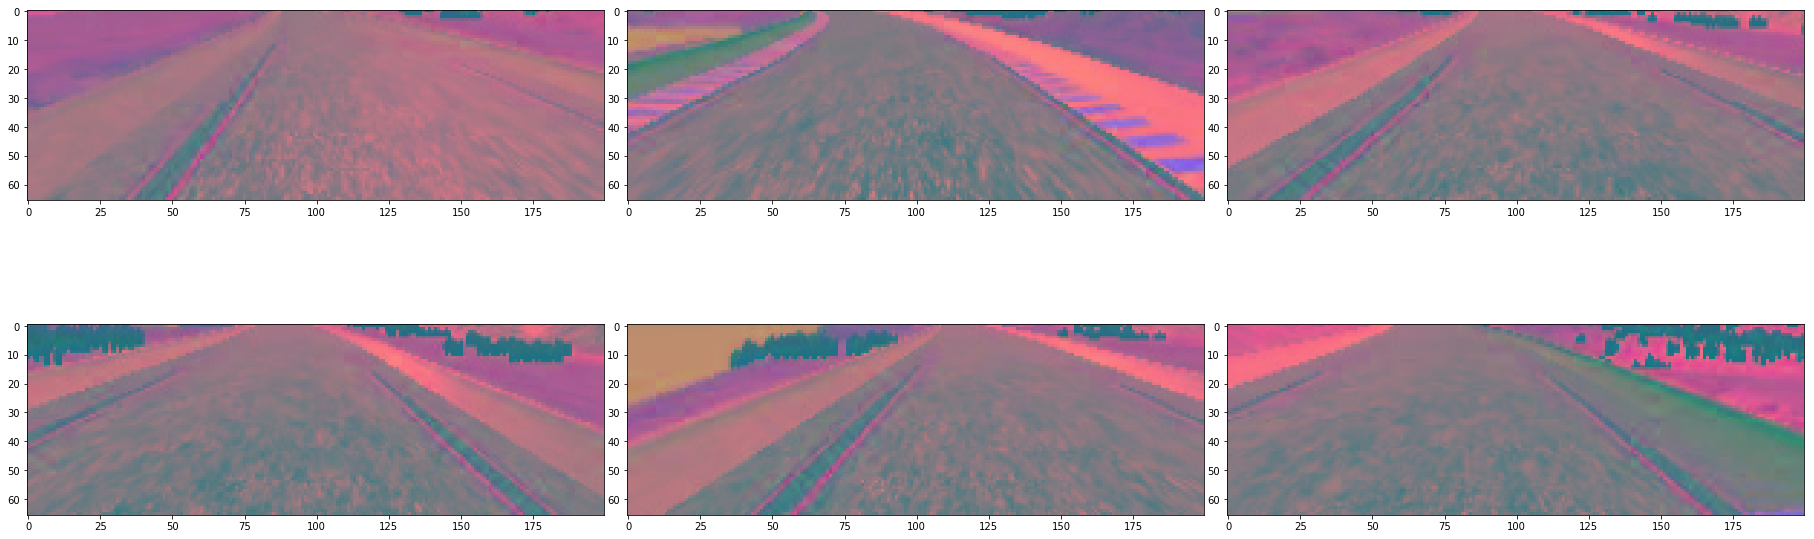

Steering angles: [ 0.45      -0.2       -0.2        0.         0.2       -0.5000001]


In [28]:
iterator = batch_generator(data_set)
X_train, y_train = next(iterator)

display_images(X_train[:6], ncols=3, figsize=(25,10))
print('Steering angles:', y_train[:6])

## 4. Network architecture and training

We choose the model developed by NVIDIA (see  [M. Bojarski et al.](https://devblogs.nvidia.com/deep-learning-self-driving-cars/)) because it is known to work well for these kind of problems. The architecture is presented in the next figure and table.

First we use a lambda-layer to normalize the data. Then five convolution layers with varying filter numbers are followed by four layers of fully-connected layers. The last layer is a single neuron which outputs the value for the steering angle.

Layer | Type | Output shape | #Params
-------|-------|-------|-------
lambda_1  | Lambda  | (66, 200, 3) |  0         
conv2d_1  | Conv2D  | (31, 98, 24) |  1824      
conv2d_2  | Conv2D  | (14, 47, 36) |  21636     
conv2d_3  | Conv2D  | (5, 22, 48)  |  43248     
conv2d_4  | Conv2D  | (3, 20, 64)  |  27712     
conv2d_5  | Conv2D  | (1, 18, 64)  |  36928     
flatten_1 | Flatten | 1152         |  0         
dense_1   | Dense   | 100          |  115300    
dense_2   | Dense   | 50           |  5050      
dense_3   | Dense   | 10           |  510       
dense_4   | Dense   | 1            |  11    

![nivida](./images/nivida_neural_network.png)

The model is implemented using keras, which allows to define the model with just a couple of lines of code (in contrast to Tensorflow). We use the RELU-activation function (ELU is another possible choice).

In [19]:
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.layers import Lambda, Conv2D, Dense, Flatten


def nivida_model():
    """Return handle to 'NIVIDA' model."""
    model = Sequential()
    model.add(Lambda(lambda x: x/127.5 - 1., input_shape=(HEIGHT, WIDTH, CHANNELS)))
    model.add(Conv2D(24, 5, 5, activation='relu', subsample=(2, 2)))
    model.add(Conv2D(36, 5, 5, activation='relu', subsample=(2, 2)))
    model.add(Conv2D(48, 5, 5, activation='relu', subsample=(2, 2)))
    model.add(Conv2D(64, 3, 3, activation='relu'))
    model.add(Conv2D(64, 3, 3, activation='relu'))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1))
    model.summary()
    return model
    

Lastly, we have to conduct the actual training of the convolutional network. We split the original data set in a training (80%) and validation set (20%). Testing is done directly in the simulator. 

For optimizing the loss function we use the adam optimizer with its default parameters. Since the problem at hand is a regression problem the mean-squared error is an appropriate error measure. So far we do not consider any regularization mechanism in our model (e.g. dropout). This can lead to overfitting easily. In order to avoid overfitting we employ early stopping i.e. we stop the fit procedure if the validation loss stops decreasing. 

For our case just five epochs are sufficient to reach approximately the point of early stopping.

In [6]:
training_set, validation_set = train_test_split(data_set, test_size=0.2)

training_generator = batch_generator(training_set, batch_size=32, is_training=True)
validation_generator = batch_generator(validation_set, batch_size=32)


model = nivida_model()
model.compile(loss='mse', optimizer='adam')
model.fit_generator(training_generator, 
                    samples_per_epoch=len(training_set), 
                    validation_data=validation_generator, 
                    nb_val_samples=len(validation_set), 
                    nb_epoch=5,
                    verbose=1)
model.save('model.h5')

/home/wca3rt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), activation="relu", strides=(2, 2))`
  # Remove the CWD from sys.path while we load stuff.
/home/wca3rt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), activation="relu", strides=(2, 2))`
  # This is added back by InteractiveShellApp.init_path()
/home/wca3rt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), activation="relu", strides=(2, 2))`
  if sys.path[0] == '':
/home/wca3rt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
  del sys.path[0]
/home/wca3rt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Upda

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 66, 200, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
__________

## 5. Results and Conclusions

The script drive.py provided by Udacity was used with two small changes to feed 'test data' to the model and perform the actual driving in the simulator. The two changes are 
* pre-processing of the images of the center camera (same pre-processing function as in this notebook)
* a speed of 15 mph was set (instead of 9 mph).

The script drive.py contains a class which keeps the speed of the car at a desired values. This helped a lot to stablize the driving of the car. The ability of our model to drive the car safely around the track is proven in this video
* [lake track](https://youtu.be/FCXi-Rv1pvk)

Although the driving style is a little bit wiggely, there does not occur any safety critical situation (i.e. no tire leaves the drivable portion of the track surface). The model can be further improved with additional data (we used just two laps of data), e.g.
* more laps of center lane driving
* center lane driving in the opposite direction
* recovery driving
* focusing on driving smoothly around curves.

Right now the model is not capable of driving another track besides the Lake track. It is a good idea to also train the model to drive on the mountain track which allows the model to generalize better. Further possible improvements are to include a dropout layer, use a regularization term for the fully-connected layers and use additional augmentation techniques. All these methods help to combat overfitting. 